In [7]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from langchain_groq import ChatGroq
from dotenv import load_dotenv, find_dotenv

In [3]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "message in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [11]:
llm = ChatGroq(
    temperature=0.5,
    groq_api_key = os.getenv('GROQ_API_KEY'),
    model_name="llama-3.3-70b-versatile"
)

In [37]:
itinerary_prompt=ChatPromptTemplate.from_messages([
    ("system"," Your are a helpful travel assistant. Create a day trip itinerary for {city} based on user's interests: {interests}. Provide a breif bulleted itinerary."),
    ("human", "Create an itinerary for my day trip.")
])


In [38]:
def input_city(state:PlannerState)-> PlannerState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your input: ")
    return {
        **state,
        "city":user_message,
        "messages":state["messages"] + [HumanMessage(content=user_message)]
    }

In [71]:
def input_interests(state:PlannerState)-> PlannerState:
    print(f"Please enter your interets for your day trip to: {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests":[interest.strip() for interest in user_message.split(",")],
        "messages":state["messages"] + [HumanMessage(content=user_message)]
    }

In [72]:
def create_itenerary(state:PlannerState)-> PlannerState:
    print(f"Creating itenerary for {state['city']} based on interests: {", ".join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests= ", ".join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages":state["messages"] + [AIMessage(content=response.content)],
        "itinerary": response.content
    }

In [73]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interests",input_interests)
workflow.add_node("create_itenerary",create_itenerary)

workflow.set_entry_point("input_city")
workflow.add_edge("input_city","input_interests")
workflow.add_edge("input_interests","create_itenerary")
workflow.add_edge("create_itenerary",END)

app = workflow.compile()

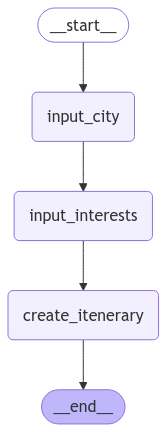

In [74]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [78]:
def travel_planner(user_request:str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests":[],
        "itinerary":"",
    }

    for output in app.stream(state):
        pass

In [79]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Please enter your interets for your day trip to: Goa (comma-separated):
Creating itenerary for Goa based on interests: Reading, Swmming

Final Itinerary: 
Here's a brief bulleted itinerary for a day trip to Goa, tailored to your interests in reading and swimming:

* 9:00 AM - 10:00 AM: Start the day with a relaxing swim at Palolem Beach, known for its tranquil and picturesque surroundings.
* 10:30 AM - 12:30 PM: Visit the Goa State Central Library in Panjim, which houses a vast collection of books and offers a peaceful atmosphere for reading.
* 1:00 PM - 2:30 PM: Take a break for lunch at a nearby restaurant, and try some local Goan cuisine.
* 3:00 PM - 5:00 PM: Head to Miramar Beach, where you can swim and enjoy the sunset while reading a book or simply relaxing.

This itinerary provides a mix of swimming, reading, and relaxation, and can be adjusted according to your preferences an